In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency
import scipy.stats as stats
%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
path = r"Data\cleaned_train.csv"

In [88]:
data = pd.read_csv(path)
print(data.shape)
data.describe()

(11898, 153)


,Serial Number,total_net_assets,net_annual_expenses_ratio,morningstar_rating,portfolio_cash,portfolio_stocks,portfolio_bonds,portfolio_others,portfolio_preferred,portfolio_convertable,...,category_102,category_103,category_104,category_105,category_106,category_107,investment_0,investment_1,investment_2,bonds_aaa
count,11898.000000,1.189800e+04,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,...,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000,11898.000000
mean,8886.317196,2.428921e+09,1.019386,2.745503,6.869599,59.288643,30.404463,1.567409,0.368650,0.632453,...,0.001933,0.000252,0.019919,0.011094,0.034712,0.006640,0.469827,0.261809,0.268364,12.442643
std,5130.876028,1.018769e+10,0.615437,1.361566,11.777783,42.114027,38.794591,6.375753,2.435118,5.239956,...,0.043926,0.015878,0.139729,0.104748,0.183056,0.081217,0.499110,0.439638,0.443127,23.614576
min,2.000000,5.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.600000
25%,4414.250000,7.008000e+07,0.620000,2.000000,1.130000,0.490000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8910.500000,3.261300e+08,0.960000,3.000000,2.960000,83.225000,1.420000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13325.750000,1.380000e+09,1.360000,4.000000,6.690000,97.450000,66.560000,0.870000,0.020000,0.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.935000
max,17773.000000,1.880000e+11,14.530000,5.000000,100.000000,100.000000,100.000000,94.710000,71.420000,93.820000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.790000


In [89]:
if "Serial Number" in data.columns:
    data.drop(columns="Serial Number", axis=1, inplace=True)

# Hypothesis Testing - Chi2

In [90]:
critical_value = stats.chi2.ppf(q = 0.95, df = 11)
critical_value

19.67513757268249

In [91]:
return_rating = data.morningstar_return_rating.value_counts()
risk_rating = data.morningstar_risk_rating.value_counts()

In [92]:
observed = pd.concat([return_rating.transpose(), risk_rating.transpose()], axis=1, keys=['return', 'risk'])
observed

,return,risk
3,3892,3845
4,2628,2614
2,2422,2218
0,1236,1236
5,956,1080
1,764,905


In [93]:
chi2, p, dof, ex = chi2_contingency(observed)

In [94]:
print(critical_value, chi2, p)

19.67513757268249 28.75585318206671 2.5889934498733718e-05


In [95]:
correlation = data.corr().abs()
us_correlation = correlation.unstack().sort_values(ascending=False)
max_correlated = us_correlation[(us_correlation<1) & (us_correlation>0.75)]
max_correlated

morningstar_return_rating  morningstar_rating           0.963584
morningstar_rating         morningstar_return_rating    0.963584
portfolio_bonds            portfolio_stocks             0.917733
portfolio_stocks           portfolio_bonds              0.917733
category_12                portfolio_convertable        0.892575
portfolio_convertable      category_12                  0.892575
sharpe_ratio_3y            mean_annual_return_3y        0.769218
mean_annual_return_3y      sharpe_ratio_3y              0.769218
dtype: float64

In [96]:
for column in ['morningstar_rating', 'portfolio_stocks', 'category_12', 'sharpe_ratio_3y']:
    if column in data.columns:
        data.drop(columns=column, axis=1, inplace=True)
data.shape

(11898, 148)

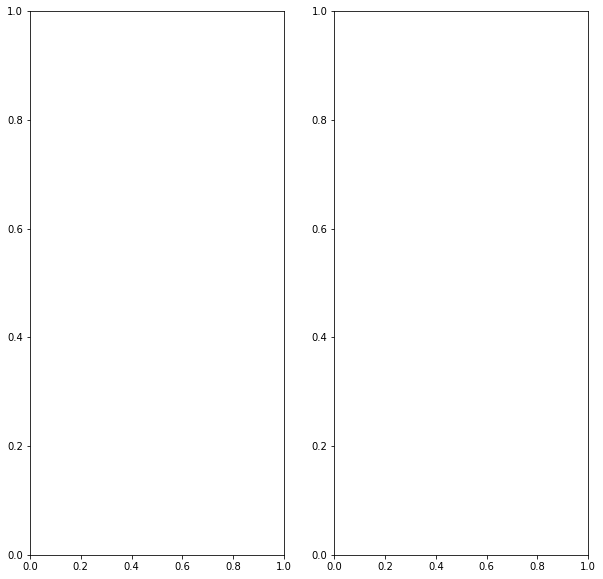

In [117]:
fig, [ax_1, ax_2] = plt.subplots(nrows=1, ncols=2,figsize=[10,10])

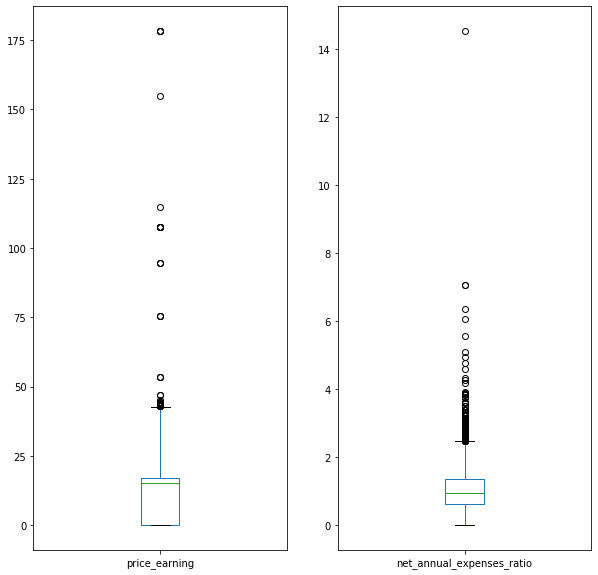

In [118]:
data.price_earning.plot(kind='box',ax=ax_1)
data.net_annual_expenses_ratio.plot(kind='box',ax=ax_2)
fig

In [134]:
X = data[data.columns[data.columns != 'bonds_aaa']]
y = data['bonds_aaa']

In [135]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)
lr = LinearRegression()

In [136]:
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

15.729889665418414

In [137]:
ridge_lambdas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
lasso_lambdas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

In [138]:
ridge_model = Ridge()
ridge_grid = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=ridge_lambdas))

In [139]:
ridge_grid.fit(X_train, y_train)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_grid.predict(X_test)))
print(ridge_rmse)

15.720131026226944

In [141]:
lasso_model = Lasso()
lasso_grid = GridSearchCV(estimator=lasso_model, param_grid=dict(alpha=lasso_lambdas))
lasso_grid.fit(X_train, y_train)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_grid.predict(X_test)))
print(lasso_rmse)

15.719153628852961
